# Assignment

In [101]:
# Import 
import numpy as np
import matplotlib.pyplot as plt
from degree_freedom_queen import *
from degree_freedom_king1 import *
from degree_freedom_king2 import *
from generate_game import *
from Chess_env import *

# Define the size of the board
size_board = 4

## The Environment

You can find the environment in the file Chess_env, which contains the class Chess_env. To define an object, you need to provide the board size considered as input. In our example, size_board=4. 
Chess_env is composed by the following methods:

1. Initialise_game. The method initialises an episode by placing the three pieces considered (Agent's king and queen, enemy's king) in the chess board. The outputs of the method are described below in order.

     S $\;$ A matrix representing the board locations filled with 4 numbers: 0, no piece in that position; 1, location of the 
     agent's king; 2 location of the queen; 3 location of the enemy king.
     
     X $\;$ The features, that is the input to the neural network. See the assignment for more information regarding the            definition of the features adopted. To personalise this, go into the Features method of the class Chess_env() and change        accordingly.
     
     allowed_a $\;$ The allowed actions that the agent can make. The agent is moving a king, with a total number of 8                possible actions, and a queen, with a total number of $(board_{size}-1)\times 8$ actions. The total number of possible actions correspond      to the sum of the two, but not all actions are allowed in a given position (movements to locations outside the borders or      against chess rules). Thus, the variable allowed_a is a vector that is one (zero) for an action that the agent can (can't)      make. Be careful, apply the policy considered on the actions that are allowed only.
     

2. OneStep. The method performs a one step update of the system. Given as input the action selected by the agent, it updates the chess board by performing that action and the response of the enemy king (which is a random allowed action in the settings considered). The first three outputs are the same as for the Initialise_game method, but the variables are computed for the position reached after the update of the system. The fourth and fifth outputs are:

     R $\;$ The reward. To change this, look at the OneStep method of the class where the rewards are set.
     
     Done $\;$ A variable that is 1 if the episode has ended (checkmate or draw).
     
     
3. Features. Given the chessboard position, the method computes the features.

This information and a quick analysis of the class should be all you need to get going. The other functions that the class exploits are uncommented and constitute an example on how not to write a python code. You can take a look at them if you want, but it is not necessary.






In [102]:
## INITIALISE THE ENVIRONMENT

env = Chess_Env(size_board)

In [103]:
## PRINT 5 STEPS OF AN EPISODE CONSIDERING A RANDOM AGENT

S, X, allowed_a = env.Initialise_game()                       # INTIALISE GAME

print(S)                                                  # PRINT CHESS BOARD (SEE THE DESCRIPTION ABOVE)

print('check? ', env.check)                                # PRINT VARIABLE THAT TELLS IF ENEMY KING IS IN CHECK (1) OR NOT (0)
print('dofk2 ', np.sum(env.dfk2_constrain).astype(int))    # PRINT THE NUMBER OF LOCATIONS THAT THE ENEMY KING CAN MOVE TO


for i in range(5):
    
    a, _ = np.where(allowed_a == 1)                  # FIND WHAT THE ALLOWED ACTIONS ARE
    a_agent = np.random.permutation(a)[0]         # MAKE A RANDOM ACTION

    S, X, allowed_a, R, Done = env.OneStep(a_agent)   # UPDATE THE ENVIRONMENT
    
    
    ## PRINT CHESS BOARD AND VARIABLES
    print('')
    print(S)
    print(R, '', Done)
    print('check? ', env.check)
    print('dofk2 ', np.sum(env.dfk2_constrain).astype(int))
    
    
    # TERMINATE THE EPISODE IF Done=True (DRAW OR CHECKMATE)
    if Done:
        break
        


[[0 0 0 0]
 [0 2 0 0]
 [0 1 0 3]
 [0 0 0 0]]
check?  0
dofk2  0

[[0 0 0 0]
 [0 0 2 0]
 [0 1 0 0]
 [0 0 0 3]]
0  0
check?  0
dofk2  0

[[0 0 0 0]
 [0 0 0 0]
 [0 1 0 0]
 [0 0 2 3]]
1  1
check?  1
dofk2  0


In [104]:
# PERFORM N_episodes=1000 EPISODES MAKING RANDOM ACTIONS AND COMPUTE THE AVERAGE REWARD AND NUMBER OF MOVES 

S, X, allowed_a = env.Initialise_game()
N_episodes = 10

# VARIABLES WHERE TO SAVE THE FINAL REWARD IN AN EPISODE AND THE NUMBER OF MOVES 
R_save_random = np.zeros([N_episodes, 1])
N_moves_save_random = np.zeros([N_episodes, 1])

for n in range(N_episodes):
    
    S, X, allowed_a = env.Initialise_game()     # INITIALISE GAME
    Done = 0                                  # SET Done=0 AT THE BEGINNING
    i = 1                                     # COUNTER FOR THE NUMBER OF ACTIONS (MOVES) IN AN EPISODE
    
    # UNTIL THE EPISODE IS NOT OVER...(Done=0)
    while Done == 0:
        
        # SAME AS THE CELL BEFORE, BUT SAVING THE RESULTS WHEN THE EPISODE TERMINATES 
        
        a, _ = np.where(allowed_a == 1)
        a_agent = np.random.permutation(a)[0]

        S, X, allowed_a, R, Done = env.OneStep(a_agent)
                
        if Done:
            
            R_save_random[n] = np.copy(R)
            N_moves_save_random[n] = np.copy(i)

            break

        i = i + 1                               # UPDATE THE COUNTER



# AS YOU SEE, THE PERFORMANCE OF A RANDOM AGENT ARE NOT GREAT, SINCE THE MAJORITY OF THE POSITIONS END WITH A DRAW 
# (THE ENEMY KING IS NOT IN CHECK AND CAN'T MOVE)

print('Random_Agent, Average reward:', np.mean(R_save_random),'Number of steps: ', np.mean(N_moves_save_random))

Random_Agent, Average reward: 0.3 Number of steps:  4.0


In [105]:
# Epsilon-Greedy Policy
def EpsilonGreedy_Policy(Qvalues, epsilon, allowed):

    N_allowed = np.shape(allowed)[0]

    Qvalues_of_allowed = Qvalues[allowed]
    
    rand_value = np.random.uniform(0,1)

    rand_a = rand_value < epsilon

    if rand_a == True:

        temp = np.random.randint(0, N_allowed)
        a = allowed[temp]

    else:

        temp = np.argmax(Qvalues_of_allowed)
        a = allowed[temp]
            
    return a

In [106]:
S, X, allowed_a = env.Initialise_game()
N_a = np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS
N_in = np.shape(X)[0]    # INPUT SIZE
N_h = 200                # NUMBER OF HIDDEN NODES

# INITALISE YOUR NEURAL NETWORK...

np.random.seed(67)

# Weights and biases
initial_W1 = np.random.randn(N_h, N_in) * 0.1
initial_b1 = np.zeros((N_h,))
initial_W2 = np.random.randn(N_a, N_h) * 0.1
initial_b2 = np.zeros((N_a,))

# HYPERPARAMETERS SUGGESTED (FOR A GRID SIZE OF 4)

epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.0035        # THE LEARNING RATE
lamb = 0
types = ["SARSA", "Q-learning"]

N_episodes = 10000 # THE NUMBER OF GAMES TO BE PLAYED 

all_N_moves = []
all_R_save = []

# Eligibility traces
eligibility_trace = True
if eligibility_trace:    
    lamb = 0.3
    eta = 0.008
    
for i in range(len(types)):
    
    # SAVING VARIABLES
    R_save = np.zeros([N_episodes, 1])
    N_moves_save = np.zeros([N_episodes, 1])
    
    learning_type = types[i] # THE LEARNING TYPE (SARSA OR Q-learning)
    
    W1 = initial_W1
    b1 = initial_b1
    W2 = initial_W2
    b2 = initial_b2

    for n in range(N_episodes):

        epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
        Done = 0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
        i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
        
        S, X, allowed_a = env.Initialise_game()      ## INITIALISE GAME
        print(str(learning_type) + " " + str(n))
        
        # Initialise eligibility traces 
        if eligibility_trace:
            e = np.zeros(N_a,)

        if learning_type == "SARSA":
            h1 = np.matmul(W1, X) + b1
            # Apply the ReLU activation function
            x1 = np.maximum(0, h1)
            # Compute Qvalues
            Qvalues = np.matmul(W2, x1) + b2
            a, _ = np.where(allowed_a == 1)
            a_agent = EpsilonGreedy_Policy(Qvalues, epsilon_f, a)

        while not Done:  ## START THE EPISODE

            # Forward propagation
            h1 = np.matmul(W1, X) + b1
            # Apply the ReLU activation function
            x1 = np.maximum(0, h1)
            # Compute Qvalues
            Qvalues = np.matmul(W2, x1) + b2
            
            if learning_type == "Q-learning":  
                a, _ = np.where(allowed_a == 1)
                a_agent = EpsilonGreedy_Policy(Qvalues, epsilon_f, a)

            S_next, X_next, allowed_a_next, R, Done = env.OneStep(a_agent)

            # Update the eligibility trace for the action made
            if eligibility_trace:

                e[a_agent] = e[a_agent] + 1

            if Done:
                
                # Backward propagation
                delta2 = R - Qvalues[a_agent]
                
                eta_delta2 = eta * delta2
                W2[a_agent] = W2[a_agent] + eta_delta2 * x1
                b2[a_agent] = b2[a_agent] + eta_delta2
                
                # update the weights of the hidden layer
                delta1 = np.dot(W2[a_agent], delta2) * (x1 > 0)

                W1 = W1 + eta * np.outer(delta1, X)
                b1 = b1 + eta * delta1

                # SAVE THE RESULTS
                # R_save[n] = np.copy(R)
                # N_moves_save[n] = np.copy(i)

                if n == 0:
                    R_save[n] = np.copy(R) * eta
                    N_moves_save[n] = np.copy(i) * eta
                else:
                    R_save[n] = (1 - eta) * R_save[n - 1] + eta * np.copy(R) 
                    N_moves_save[n] = (1 - eta) * N_moves_save[n - 1] + eta * np.copy(i) 

                if eligibility_trace:
                    W2 = W2 + eta_delta2 * np.outer(e, x1)

                break
            
            else:

                h1 = np.matmul(W1, X_next) + b1
                
                # Apply the ReLU activation function
                x1 = np.maximum(0, h1)

                # Compute Qvalues
                Qvalues1 = np.matmul(W2, x1) + b2
                
                a1, _ = np.where(allowed_a_next == 1)

                if learning_type == "SARSA":
                    a1_agent = EpsilonGreedy_Policy(Qvalues1, epsilon_f, a1)
                else:
                    # Since EpsilonGreedy_Policy retrieves the index of the maximum of the Qvalues, we can use it for Q-learning
                    a1_agent = EpsilonGreedy_Policy(Qvalues1, 0, a)
                    # a1_agent = EpsilonGreedy_Policy(Qvalues, 0, a1)
                    
                # Backward propagation
                delta2 = R + gamma * Qvalues1[a1_agent] - Qvalues[a_agent]

                eta_delta2 = eta * delta2
                
                W2[a_agent] = W2[a_agent] + eta_delta2 * x1
                b2[a_agent] = b2[a_agent] + eta_delta2

                delta1 = np.dot(W2[a_agent], delta2) * (x1 > 0)

                W1 = W1 + eta * np.outer(delta1, X)
                b1 = b1 + eta * delta1

                if eligibility_trace:
                    W2 = W2 + eta_delta2 * np.outer(e, x1)
                    e = gamma * lamb * e
                
            # NEXT STATE AND CO. BECOME ACTUAL STATE...
            S = np.copy(S_next)
            X = np.copy(X_next)
            allowed_a = np.copy(allowed_a_next)

            if learning_type == "SARSA":
                a_agent = np.copy(a1_agent)
            
            i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS
    
    all_N_moves.append(N_moves_save)
    all_R_save.append(R_save)    

SARSA 0
SARSA 1
SARSA 2
SARSA 3
SARSA 4
SARSA 5
SARSA 6
SARSA 7
SARSA 8
SARSA 9
SARSA 10
SARSA 11
SARSA 12
SARSA 13
SARSA 14
SARSA 15
SARSA 16
SARSA 17
SARSA 18
SARSA 19
SARSA 20
SARSA 21
SARSA 22
SARSA 23
SARSA 24
SARSA 25
SARSA 26
SARSA 27
SARSA 28
SARSA 29
SARSA 30
SARSA 31
SARSA 32
SARSA 33
SARSA 34
SARSA 35
SARSA 36
SARSA 37
SARSA 38
SARSA 39
SARSA 40
SARSA 41
SARSA 42
SARSA 43
SARSA 44
SARSA 45
SARSA 46
SARSA 47
SARSA 48
SARSA 49
SARSA 50
SARSA 51
SARSA 52
SARSA 53
SARSA 54
SARSA 55
SARSA 56
SARSA 57
SARSA 58
SARSA 59
SARSA 60
SARSA 61
SARSA 62
SARSA 63
SARSA 64
SARSA 65
SARSA 66
SARSA 67
SARSA 68
SARSA 69
SARSA 70
SARSA 71
SARSA 72
SARSA 73
SARSA 74
SARSA 75
SARSA 76
SARSA 77
SARSA 78
SARSA 79
SARSA 80
SARSA 81
SARSA 82
SARSA 83
SARSA 84
SARSA 85
SARSA 86
SARSA 87
SARSA 88
SARSA 89
SARSA 90
SARSA 91
SARSA 92
SARSA 93
SARSA 94
SARSA 95
SARSA 96
SARSA 97
SARSA 98
SARSA 99
SARSA 100
SARSA 101
SARSA 102
SARSA 103
SARSA 104
SARSA 105
SARSA 106
SARSA 107
SARSA 108
SARSA 109
SARSA 110


C:\Users\acb19cg\AppData\Local\Temp\ipykernel_10992\2656536831.py:78: RuntimeWarning: overflow encountered in matmul
  Qvalues = np.matmul(W2, x1) + b2
C:\Users\acb19cg\AppData\Local\Temp\ipykernel_10992\2656536831.py:130: RuntimeWarning: overflow encountered in matmul
  Qvalues1 = np.matmul(W2, x1) + b2
C:\Users\acb19cg\AppData\Local\Temp\ipykernel_10992\2656536831.py:146: RuntimeWarning: overflow encountered in multiply
  W2[a_agent] = W2[a_agent] + eta_delta2 * x1
c:\Anaconda\lib\site-packages\numpy\core\numeric.py:936: RuntimeWarning: invalid value encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
C:\Users\acb19cg\AppData\Local\Temp\ipykernel_10992\2656536831.py:155: RuntimeWarning: overflow encountered in multiply
  W2 = W2 + eta_delta2 * np.outer(e, x1)
C:\Users\acb19cg\AppData\Local\Temp\ipykernel_10992\2656536831.py:74: RuntimeWarning: invalid value encountered in matmul
  h1 = np.matmul(W1, X) + b1
C:\Users\acb19cg\AppData\Local\Temp\

Q-learning 3623
Q-learning 3624
Q-learning 3625
Q-learning 3626
Q-learning 3627
Q-learning 3628
Q-learning 3629
Q-learning 3630
Q-learning 3631
Q-learning 3632
Q-learning 3633
Q-learning 3634
Q-learning 3635
Q-learning 3636
Q-learning 3637
Q-learning 3638
Q-learning 3639
Q-learning 3640
Q-learning 3641
Q-learning 3642
Q-learning 3643
Q-learning 3644
Q-learning 3645
Q-learning 3646
Q-learning 3647
Q-learning 3648
Q-learning 3649
Q-learning 3650
Q-learning 3651
Q-learning 3652
Q-learning 3653
Q-learning 3654
Q-learning 3655
Q-learning 3656
Q-learning 3657
Q-learning 3658
Q-learning 3659
Q-learning 3660
Q-learning 3661
Q-learning 3662
Q-learning 3663
Q-learning 3664
Q-learning 3665
Q-learning 3666
Q-learning 3667
Q-learning 3668
Q-learning 3669
Q-learning 3670
Q-learning 3671
Q-learning 3672
Q-learning 3673
Q-learning 3674
Q-learning 3675
Q-learning 3676
Q-learning 3677
Q-learning 3678
Q-learning 3679
Q-learning 3680
Q-learning 3681
Q-learning 3682
Q-learning 3683
Q-learning 3684
Q-learni

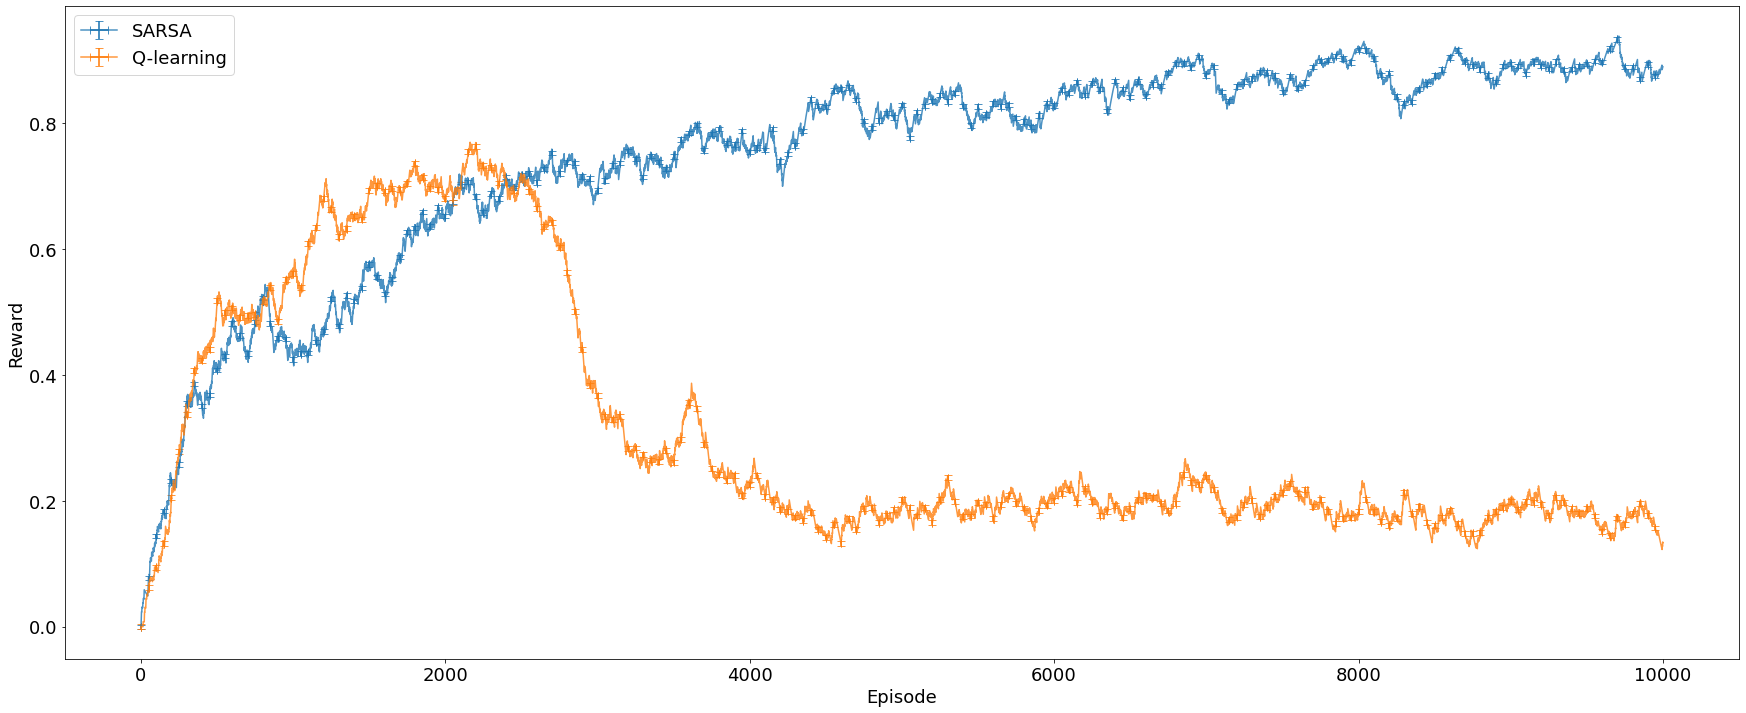

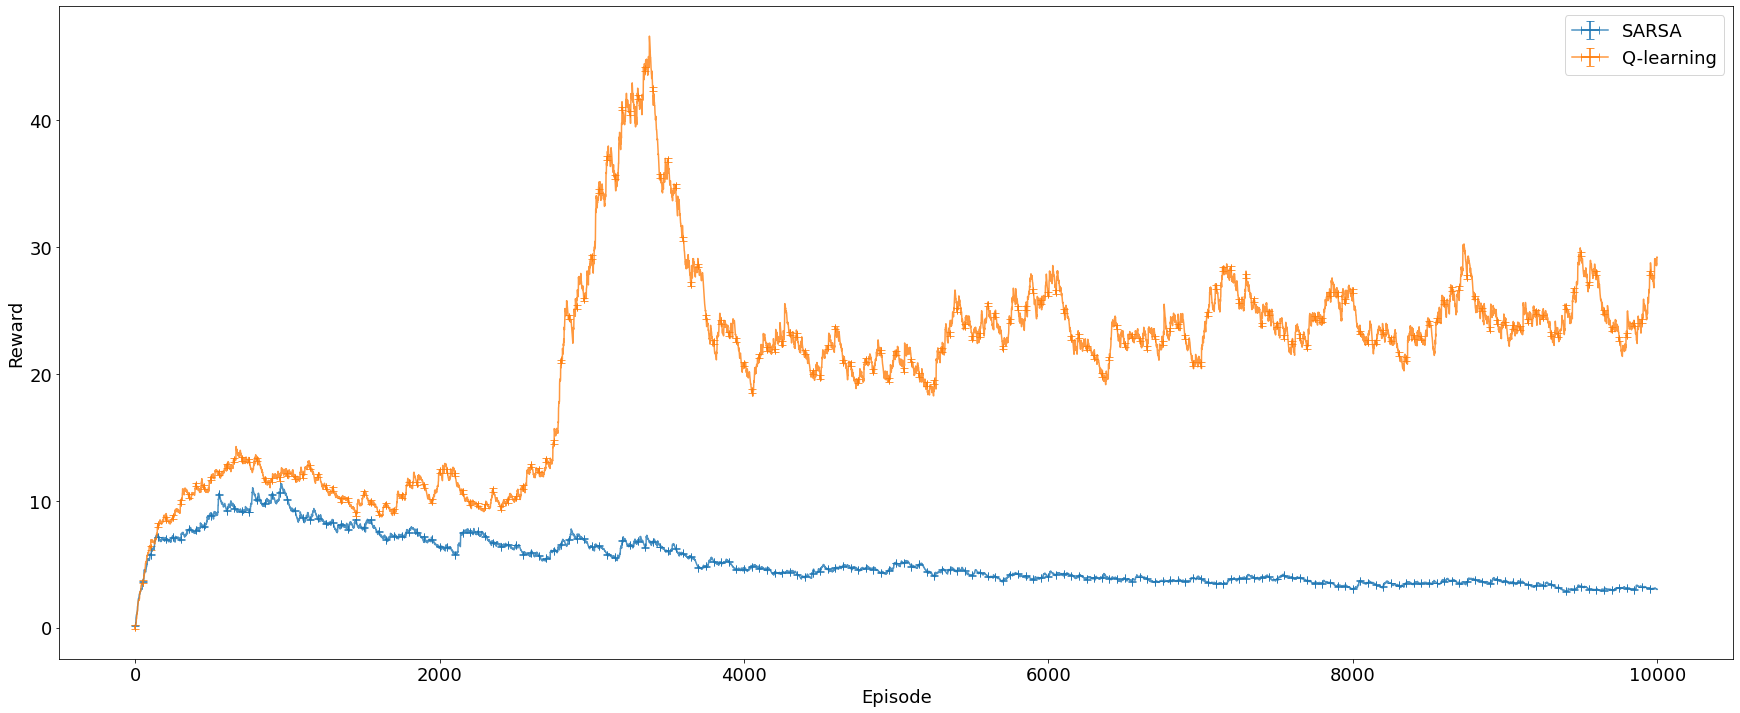

In [107]:
plt.figure(figsize=(30, 12))
for i, R_save in enumerate(all_R_save):
    errors = 2 * np.std(R_save) / np.sqrt(N_episodes) 
    plt.errorbar(np.arange(N_episodes), R_save.flatten(), errors, 0, elinewidth=2, capsize=4, alpha=0.8, errorevery=50)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.rcParams.update({'font.size': 18})
labels = ["SARSA", "Q-learning"]  # Add more labels if needed
plt.legend(labels)
plt.savefig('EMA_Reward.pdf')

plt.figure(figsize=(30, 12))
for i, N_moves_save in enumerate(all_N_moves):
    errors = 2 * np.std(N_moves_save) / np.sqrt(N_episodes) 
    plt.errorbar(np.arange(N_episodes), N_moves_save.flatten(), errors, 0, elinewidth=2, capsize=4, alpha=0.8, errorevery=50)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.rcParams.update({'font.size': 18})
labels = ["SARSA", "Q-learning"]  # Add more labels if needed
plt.legend(labels)
plt.savefig('EMA_Moves.pdf')